In [ ]:
# モデルの保存先を指定
# 作成後は~/jpx/predict/modelにmy_model_label_high_20.pklとmy_model_label_low_20.pkl
model_path = "./model"

In [1]:
import sys
import os
import datetime
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

import xgboost as xgb
from tqdm import tqdm

sys.path.append('/home/jupyter/jpx/')
sys.path.append('/home/jupyter/jpx/predict/src')
from pipeline import ml_pipeline
from predictor import ScoringService 



DATASET_DIR='/home/jupyter/jpx/data'
MODEL_PATH="/home/jupyter/jpx/predict/model"

pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/o

In [2]:
inputs = ScoringService.get_inputs(DATASET_DIR)
inputs

{'stock_list': '/root/milize_project/jpx/data/stock_list.csv.gz',
 'stock_price': '/root/milize_project/jpx/data/stock_price.csv.gz',
 'stock_fin': '/root/milize_project/jpx/data/stock_fin.csv.gz',
 'stock_labels': '/root/milize_project/jpx/data/stock_labels.csv.gz'}

In [3]:
dfs = ScoringService.get_dataset(inputs)
codes = ScoringService.get_codes(dfs)

In [4]:
dfs['stock_labels']['Local Code']

datetime
2016-01-04    1301
2016-01-05    1301
2016-01-06    1301
2016-01-07    1301
2016-01-08    1301
              ... 
2021-03-22    9997
2021-03-23    9997
2021-03-24    9997
2021-03-25    9997
2021-03-26    9997
Name: Local Code, Length: 4394888, dtype: int64

In [5]:
stock_list = dfs['stock_list'].rename(columns={'Local Code':'code'})

In [6]:
stock_list

,prediction_target,Effective Date,code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20210226,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2021/02/05,10928283.0
1,True,20210226,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/05,312430277.0
2,True,20210226,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/08,52656910.0
3,True,20210226,1352,HOHSUI CORPORATION,First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/29,8379000.0
4,True,20210226,1376,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2021/01/05,11772626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,True,20210226,9993,"YAMAZAWA CO.,LTD.",First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/08,10960825.0
3519,True,20210226,9994,YAMAYA CORPORATION,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/02/15,10847870.0
3520,True,20210226,9995,"GLOSEL Co.,Ltd.",First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/28,26426800.0
3521,True,20210226,9996,"Satoh&Co.,Ltd.",JASDAQ(Standard / Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,-,-,ConsolidatedJP,2021/02/10,9152640.0


In [7]:
# 10分くらいかかります
feats = ScoringService.get_features_for_predict(codes, is_dask=True)

INFO : 2021-03-28 04:34:50,685 : exec FE by dask
INFO : 2021-03-28 04:41:34,243 : price_indicator FE end
INFO : 2021-03-28 04:41:34,243 : start lag FE
INFO : 2021-03-28 04:43:21,958 : end lag FE


In [8]:
feats

EndOfDayQuote ExchangeOfficialClose  \
Local Code datetime                                          
1436       2016-03-11                               1510.0   
           2016-03-14                               1405.0   
           2016-03-15                               1489.0   
           2016-03-16                               1477.0   
           2016-03-17                               1415.0   
...                                                    ...   
9974       2021-03-22                               6260.0   
           2021-03-23                               6120.0   
           2021-03-24                               6130.0   
           2021-03-25                               6280.0   
           2021-03-26                               6260.0   

                       EndOfDayQuote Volume        rsi         atr  \
Local Code datetime                                                  
1436       2016-03-11             2009800.0        NaN         NaN   
           2016-03-14              413800.0        NaN         NaN   
           2016-03-15              164700.0        NaN         NaN   
           2016-03-16               76700.0        NaN         NaN   
           2016-03-17               65200.0        NaN         NaN   
...                                     ...        ...         ...   
9974       2021-03-22               55300.0  70.800666  499.099810   
           2021-03-23               28700.0  60.962503  512.021252   
           2021-03-24               56000.0  61.375358  521.876877   
           2021-03-25               40600.0  67.011194  532.457100   
           2021-03-26               28600.0  65.636014  531.567307   

                             macd       signal    dollar_vol  return_1d  \
Local Code datetime                                                       
1436       2016-03-11         NaN          NaN  3.034798e+09        NaN   
           2016-03-14         NaN          NaN  5.813890e+08  -0.069536   
           2016-03-15         NaN          NaN  2.452383e+08   0.059786   
           2016-03-16         NaN          NaN  1.132859e+08  -0.008059   
           2016-03-17         NaN          NaN  9.225800e+07  -0.041977   
...                           ...          ...           ...        ...   
9974       2021-03-22  150.254586  6003.333333  3.461780e+08   0.009677   
           2021-03-23  154.236464  6043.333333  1.756440e+08  -0.022364   
           2021-03-24  158.487106  6078.888889  3.432800e+08   0.001634   
           2021-03-25  170.042110  6124.444444  2.549680e+08   0.024470   
           2021-03-26  174.462460  6157.777778  1.790360e+08  -0.003185   

                       return_5d  return_10d  return_21d  return_42d  \
Local Code datetime                                                    
1436       2016-03-11        NaN         NaN         NaN         NaN   
           2016-03-14        NaN         NaN         NaN         NaN   
           2016-03-15        NaN         NaN         NaN         NaN   
           2016-03-16        NaN         NaN         NaN         NaN   
           2016-03-17        NaN         NaN         NaN         NaN   
...                          ...         ...         ...         ...   
9974       2021-03-22   0.009870    0.011023    0.004055    0.001737   
           2021-03-23   0.003300    0.005732    0.002808    0.001362   
           2021-03-24   0.002631    0.006245    0.003386    0.001401   
           2021-03-25   0.005833    0.007809    0.005131    0.001813   
           2021-03-26   0.001928    0.006453    0.005749    0.001901   

                       return_63d  return_1d_lag1  return_5d_lag1  \
Local Code datetime                                                 
1436       2016-03-11         NaN             NaN             NaN   
           2016-03-14         NaN             NaN             NaN   
           2016-03-15         NaN       -0.069536             NaN   
           2016-03-16         NaN        0.0597

In [9]:
# ファンダメンタル情報（決算数値データや配当データ等）の追加
df_fundamental_feature = ScoringService.get_fundamental_feature(feats, codes)

In [10]:
stock_list

,prediction_target,Effective Date,code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20210226,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2021/02/05,10928283.0
1,True,20210226,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/05,312430277.0
2,True,20210226,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2021/02/08,52656910.0
3,True,20210226,1352,HOHSUI CORPORATION,First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/29,8379000.0
4,True,20210226,1376,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2021/01/05,11772626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,True,20210226,9993,"YAMAZAWA CO.,LTD.",First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/08,10960825.0
3519,True,20210226,9994,YAMAYA CORPORATION,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/02/15,10847870.0
3520,True,20210226,9995,"GLOSEL Co.,Ltd.",First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/28,26426800.0
3521,True,20210226,9996,"Satoh&Co.,Ltd.",JASDAQ(Standard / Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,-,-,ConsolidatedJP,2021/02/10,9152640.0


In [16]:
# 銘柄の名前や業種区分などの基本情報の
df_learning = ScoringService.calc_fundamental_feature(df_fundamental_feature)

In [17]:
df_learning

,code,base_date,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,...,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,prediction_target,Effective Date,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,market_cap,per,pbr,roe,profit_margin,equity_ratio
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0,4710.0,12200.0,NaN,NaN,NaN,NaN,5.746200e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12,0.01062,-0.04034,2016-01-19,0.01062,-0.05945,2016-02-02,0.03609,-0.10616,2016/01/04,4750.0,4800.0,4620.0,4710.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598,True,20210226,"AMIYAKI TEI CO.,LTD.",First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,3.225785e+10,19.609634,1.901771,0.096981,0.073589,0.79

In [18]:
feature_columns = ScoringService.get_feature_columns(dfs, feats)

In [19]:
# 使用する特徴量
feature_columns

['Result_FinancialStatement FiscalYear',
 'Result_FinancialStatement NetSales',
 'Result_FinancialStatement OperatingIncome',
 'Result_FinancialStatement OrdinaryIncome',
 'Result_FinancialStatement NetIncome',
 'Result_FinancialStatement TotalAssets',
 'Result_FinancialStatement NetAssets',
 'Result_FinancialStatement CashFlowsFromOperatingActivities',
 'Result_FinancialStatement CashFlowsFromFinancingActivities',
 'Result_FinancialStatement CashFlowsFromInvestingActivities',
 'Forecast_FinancialStatement FiscalYear',
 'Forecast_FinancialStatement NetSales',
 'Forecast_FinancialStatement OperatingIncome',
 'Forecast_FinancialStatement OrdinaryIncome',
 'Forecast_FinancialStatement NetIncome',
 'Result_Dividend FiscalYear',
 'Result_Dividend QuarterlyDividendPerShare',
 'Result_Dividend AnnualDividendPerShare',
 'Forecast_Dividend FiscalYear',
 'Forecast_Dividend QuarterlyDividendPerShare',
 'Forecast_Dividend AnnualDividendPerShare',
 'IssuedShareEquityQuote IssuedShare',
 'market_cap

In [20]:
import config

fundamental_cols_category =  config.fundamental_cols_category

# カテゴリー
for i in fundamental_cols_category:
    print(i)
    print(df_learning[i].unique())
    print('-------------')


Result_FinancialStatement AccountingStandard
['ConsolidatedJP' 'NaN' 'NonConsolidated' 'ConsolidatedIFRS'
 'ConsolidatedUS']
-------------
Result_FinancialStatement ReportType
['Q3' 'NaN' 'Q2' 'Q1' 'Annual']
-------------
Result_FinancialStatement CompanyType
['GB' 'NaN' 'SE' 'BK' 'IN']
-------------
Result_FinancialStatement ChangeOfFiscalYearEnd
['False' 'NaN' 'True']
-------------
Forecast_FinancialStatement AccountingStandard
['ConsolidatedJP' 'NonConsolidated' 'ConsolidatedIFRS' 'NaN'
 'ConsolidatedUS']
-------------
Forecast_FinancialStatement ReportType
['Annual' 'Q2' 'NaN' 'Q3' 'Q1']
-------------
Forecast_FinancialStatement CompanyType
['GB' 'NaN' 'SE' 'BK' 'IN']
-------------
Forecast_FinancialStatement ChangeOfFiscalYearEnd
['False' 'NaN' 'True']
-------------
Result_Dividend ReportType
['NaN' 'Annual' 'Q3' 'Q1' 'Q2']
-------------
Forecast_Dividend ReportType
['Annual' 'Q2' 'NaN' 'Q3' 'Q1']
-------------
Section/Products
['First Section (Domestic)' 'JASDAQ(Standard / Domest

In [45]:
labels = [
    "label_high_20",
    "label_low_20",
]


# データ分割期間を定義
TRAIN_END = "2020-12-31"
VAL_START = "2021-01-01"
VAL_END = "2020-12-31"
TEST_START = "2021-01-01"

# モデルを定義
models = {
    "rf": RandomForestRegressor(max_depth=5, random_state=0),
    "LinearRegression" : LinearRegression(),
    "xgb": xgb.XGBRegressor(max_depth=6, learning_rate=0.02)
}


train =  df_learning.loc[: TRAIN_END]
val = df_learning.loc[VAL_START : ]
#test = df_learning.loc[TEST_START :]

# モデルを選択
model = "xgb"

# 目的変数を指定
label = "label_low_20"


# 特徴量グループを指定
col = "fundamental+technical"

pred_model = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)
if model != 'xgb': 
    pred_model.fit(train[feature_columns].fillna(-1), train[label])
else:
    pred_model.fit(train[feature_columns], train[label])

,predict,actual
predict,1.000000,0.214862
actual,0.214862,1.000000


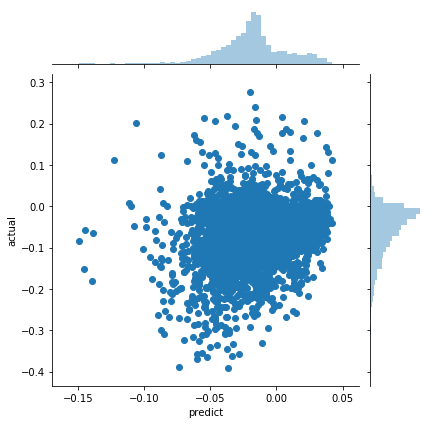

0.1821534632794107

In [46]:
import importlib
import learner.preprocessors
importlib.reload( learner.preprocessors)
import  learner.preprocessors
from learner.preprocessors import ExperimentManagement


exp = ExperimentManagement(df_learning=df_learning, feature_columns=feature_columns)
exp.set_model_label(model=models[model], label=label)
result = exp.get_result(pred_model, val, is_plot=True)
spearmanr(result[label]["actual"], result[label]["predict"])[0]

# 検証1 大きくずれているものを検証

In [47]:
df_bench = pd.DataFrame(
    pred_model.predict(train[feature_columns]), columns=["predict"]
)
df_bench["actual"] = train[label].values
df_bench["datetime"] = train[feature_columns].index
df_bench["code"] = train["code"].values
df_bench = df_bench.set_index('datetime')

df_bench['diff_abs'] = abs(df_bench["actual"] - df_bench["predict"] )
df_bench['diff'] = df_bench["actual"] - df_bench["predict"]
df_bench = df_bench.sort_values(by='diff_abs', ascending=False)

df_predict = result[label]
df_predict['diff_abs'] = abs(df_predict["actual"] - df_predict["predict"] )

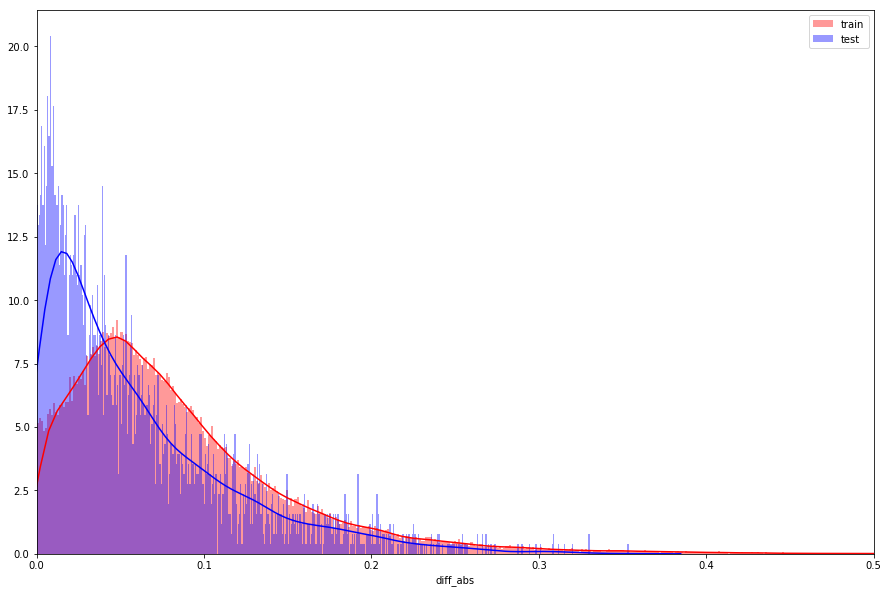

In [48]:
plt.figure(figsize=(15, 10))
sns.distplot(
   df_bench['diff_abs'] , bins=500, color='r', label='train',
    kde=True
)
sns.distplot(
   df_predict['diff_abs'] , bins=500, color='b', label='test',
    kde=True
)
plt.xlim([0, 0.5])
plt.legend()
plt.show()

In [49]:
df_bench[df_bench.diff_abs>0.5] # こいつ抜くとどうなる？


# 株式会社　安永 の2016-11-10

,predict,actual,code,diff_abs,diff
datetime,,,,,
2020-02-13,-0.017263,-0.62857,1400,0.611307,-0.611307
2019-08-02,-0.048177,-0.65340,8938,0.605223,-0.605223
2019-02-07,-0.009530,-0.61359,8848,0.604060,-0.604060
2020-02-14,-0.074003,-0.66092,7782,0.586917,-0.586917
2020-02-14,-0.145336,-0.72045,9272,0.575114,-0.575114
2018-12-03,-0.057154,-0.63158,3686,0.574426,-0.574426
2020-02-13,-0.038402,-0.60194,6177,0.563538,-0.563538
2019-01-28,-0.230395,-0.78563,4592,0.555235,-0.555235
2020-03-06,-0.068945,-0.62346,3479,0.554515,-0.554515


In [50]:
df_result_train = train.copy()
df_result_train = pd.merge(df_result_train.reset_index(), df_bench.reset_index(), on=['datetime', 'code'], how='left')

In [51]:
# 全体の平均は0.08588004057153045 +/- 0.16217730452814788


df_result_17sec = df_result_train.groupby('17 Sector(Code)')['diff_abs'].describe().sort_values(by='mean')
pd.merge(df_result_17sec.reset_index(), dfs['stock_list'][['17 Sector(Code)', '17 Sector(name)']].astype(str).drop_duplicates(),
         on=['17 Sector(Code)'])


,17 Sector(Code),count,mean,std,min,25%,50%,75%,max,17 Sector(name)
0,1,3018.0,0.069110,0.054121,5.265657e-05,0.035231,0.055985,0.088233,0.545525,FOODS
1,12,2563.0,0.072208,0.049894,1.765695e-04,0.038986,0.061942,0.093467,0.500993,TRANSPORTATION & LOGISTICS
2,11,528.0,0.073112,0.052457,6.534408e-04,0.037959,0.062991,0.095278,0.392802,ELECTRIC POWER & GAS
3,14,7711.0,0.077603,0.065558,2.276264e-06,0.033762,0.059523,0.103312,0.525812,RETAIL TRADE
4,13,7102.0,0.079133,0.059651,5.640672e-06,0.039816,0.065607,0.101458,0.531698,COMMERCIAL & WHOLESALE TRADE
5,5,1506.0,0.080721,0.070779,5.615303e-05,0.031836,0.063819,0.107291,0.555235,PHARMACEUTICAL
6,15,1836.0,0.080855,0.050630,8.299085e-05,0.044193,0.072310,0.108193,0.408951,BANKS
7,2,399.0,0.081051,0.061185,7.930231e-04,0.036119,0.069565,0.108978,0.419668,ENERGY RESOURCES
8,4,6441.0,0.081372,0.059987,2.024737e-07,0.039565,0.068574,0.107683,0.538622,RAW MATERIALS & CHEMICALS
9,3,6914.0,0.081383,0.061437,4.662814e-05,0.039126,0.067970,0.107693,0.611307,CONSTRUCTION & MATERIALS


In [52]:
train_re = df_result_train[df_result_train['diff_abs']<0.5]
train_augm_target = df_result_train[df_result_train['datetime']>'2020-10-01']

train_augm_target = pd.concat([train_augm_target]*1)
train_re_augm = pd.concat([train_re.set_index('datetime'), train_augm_target.set_index('datetime')])


In [53]:
pred_model_re = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)
pred_model_re.fit(train_re_augm[feature_columns], train_re_augm[label])


Pipeline(memory=None,
     steps=[('categorical_encoder', TransformerWrapper(transformer=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
          variables=['Result_FinancialStatement AccountingStandard', 'Result_FinancialStatement ReportType', 'Result_FinancialStatement CompanyType', 'Result_FinancialState...w Index Series)', 'Size (New Index Series)', 'IssuedShareEquityQuote AccountingStandard', 'code']))])

,predict,actual
predict,1.000000,0.269113
actual,0.269113,1.000000


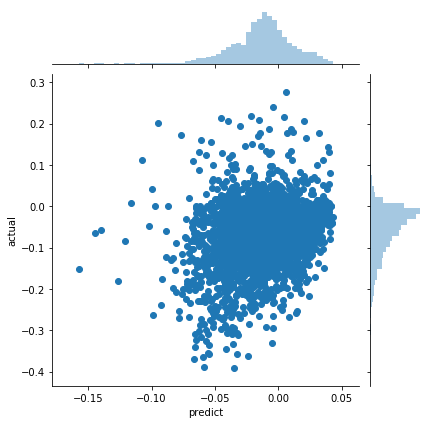

0.230190340359344

In [54]:
result = exp.get_result(pred_model_re, val, is_plot=True)

spearmanr(result[label]["actual"], result[label]["predict"])[0]


#増やさない ピアソン->0.174036、　spearman→0.11690880
# 増やすピアソン->0.168285、　spearman→0.1425730

In [55]:
# モデル作成

labels = [
    "label_high_20",
    "label_low_20",
]


# データ分割期間を定義
TRAIN_END = "2020-12-31"
VAL_START = "2021-01-01"

# モデルを定義
models = {
    "rf": RandomForestRegressor(max_depth=5, random_state=0),
    "LinearRegression" : LinearRegression(),
    "xgb": xgb.XGBRegressor(max_depth=6, learning_rate=0.02, n_estimators=1000,  random_state=0)
}


train =  df_learning.copy()
#val = df_learning.loc[VAL_START : ]
#test = df_learning.loc[TEST_START :]

# モデルを選択
model = "xgb"



# 特徴量グループを指定
col = "fundamental+technical"

pred_model = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)
if model != 'xgb': 
    pred_model.fit(train[feature_columns].fillna(-1), train[label])
else:
    pred_model.fit(train[feature_columns], train[label])
    
    
df_bench = pd.DataFrame(
    pred_model.predict(train[feature_columns]), columns=["predict"]
)
df_bench["actual"] = train[label].values
df_bench["datetime"] = train[feature_columns].index
df_bench["code"] = train["code"].values
df_bench = df_bench.set_index('datetime')

df_bench['diff_abs'] = abs(df_bench["actual"] - df_bench["predict"] )
df_bench['diff'] = df_bench["actual"] - df_bench["predict"]
df_bench = df_bench.sort_values(by='diff_abs', ascending=False)


df_result_train = train.copy()
df_result_train = pd.merge(df_result_train.reset_index(), df_bench.reset_index(), on=['datetime', 'code'], how='left')



train_re = df_result_train[df_result_train['diff_abs']<0.5]
train_augm_target = df_result_train[df_result_train['datetime']>'2020-10-01']

train_augm_target = pd.concat([train_augm_target]*1)
train_re_augm = pd.concat([train_re.set_index('datetime'), train_augm_target.set_index('datetime')])


pred_model_re = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)
pred_model_re.fit(train_re_augm[feature_columns], train_re_augm[label])


Pipeline(memory=None,
     steps=[('categorical_encoder', TransformerWrapper(transformer=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
          variables=['Result_FinancialStatement AccountingStandard', 'Result_FinancialStatement ReportType', 'Result_FinancialStatement CompanyType', 'Result_FinancialState...w Index Series)', 'Size (New Index Series)', 'IssuedShareEquityQuote AccountingStandard', 'code']))])

In [56]:

# モデル保存用にメソッドを定義します
def save_model(model, label, model_path="../model"):
    # モデル保存先ディレクトリを作成
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        # モデルをpickle形式で保存
        pickle.dump(model, f)

# 保存した学習済みモデルから、提出するモデルを選択してpickle形式で保存します。
# 使用するモデルや特徴量を変更する際は、学習時と推論時で同一の特徴量をモデルに
# 入力するために提出用のpredictor.pyについても変更する必要があることにご注意ください。

# モデルの保存先を指定します。

# モデルの種類



# モデルを保存
save_model(pred_model_re, label, model_path=model_path)